Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.sparse.linalg import eigsh
import umap
from scipy.cluster import hierarchy
import hdbscan

from sklearn.preprocessing import StandardScaler

np.random.seed(1)

Variable Descriptions

In [2]:
# Mortgage              = Total Home Mortgage Balance Amount  
# Card Utilization      = Ratio of Credit Card balances to max limit 
# Amount Past Due       = Total Amount Past Due 

# Card Balance          = Overall Credit Card balances in current month 
# Card Balance_nm       = Overall Credit Card balances in the last n months

# Credit Inquiry        = Total number of inquiries made in current month
# Credit Inquiry_nm     = Total number of inquiries made in the last n months

# Open Trade*           = Total number of open trades presently satisfactory reported in current 
#                           month and trades are opened 12 months or older 
# Open Trade_nm         = Total number of open trades presently satisfactory reported in the last n 
#                           months and trades are opened 12 months or older 


# Delinquency Status    = Total number of trades ever derogatory including collections 
#                           (excluding satisfied medical collections) 
# Delinquency Status_nm = Total number of trades ever derogatory including collections (excluding 
#                           satisfied medical collections) in the last n months

# DDA Balance_9m        = Minimum DDA Balances with XYZ bank in last 9 months 
#                           DDA stands for Demand Deposit Accounts such as checking and saving accounts 

# Gender                = 1 if gender is Male and 0 else
# Race                  = 1 if race is White and 0 else
# Race Category         = Race by category 

# Status                = 1 Never delinquent or at most 29 consecutive days 
#                           past due in the last 24 months and 0 else

# WE HAVE NUMERIC, LAGGED NUMERIC, AND DEMOGRAPHIC DATA TO PERFORM BINARY CLASSIFICATION

EDA

In [3]:
data_dir = '../data'
raw, processed = 'raw', 'processed'

train_fname = 'train_PresSE_SRF_747.csv'
test_fname = 'test_PresSE_SRF_747.csv'

train = pd.read_csv(f'{data_dir}/{processed}/{train_fname}')

In [4]:
train['race_category'].value_counts()

race_category
White       9088
Hispanic    6002
Black       2872
Asian       1080
Unknown      958
Name: count, dtype: int64

In [5]:
train[['mortgage', 'amount_past_due', 'dda_balance_9m', 'card_balance']].describe().T.iloc[:, 1:].round(2)

,mean,std,min,25%,50%,75%,max
mortgage,222327.30,92847.40,108212.11,156268.62,194104.62,261449.09,1.207620e+06
amount_past_due,100265.82,9999747.34,0.00,0.00,0.00,247.15,1.000000e+09
dda_balance_9m,150772.66,12246826.96,0.00,0.00,0.00,0.00,1.000000e+09
card_balance,1237.72,1295.86,2.02,382.33,818.48,1621.15,1.591293e+04


In [6]:
p = .995
for col_name in ('amount_past_due', 'dda_balance_9m'):
    print(f'{ round(p*100, 1) }th percentile for {col_name} is: { np.round( np.quantile(train[col_name], p), 2) }')

99.5th percentile for amount_past_due is: 3934.19
99.5th percentile for dda_balance_9m is: 10709.01


In [7]:
# amount_past_due > $15k or dda_balance_9m > $150K seems unreasonable give the 99.5 %ile values for both
train[(train['amount_past_due'] > 1.5e4) | (train['dda_balance_9m'] > 1.5e5)]

,mortgage,card_utilization,amount_past_due,dda_balance_9m,card_balance,card_balance_3m,card_balance_6m,card_balance_12m,delinquency_status,delinquency_status_3m,...,credit_inquiry_6m,credit_inquiry_12m,open_trade,open_trade_3m,open_trade_6m,open_trade_12m,gender,race,race_category,status
134,330431.07,0.328861,1.000000e+09,0.000000e+00,797.61,1748.72,1803.21,2071.76,0,0,...,4,0,0,0,3,0,1,1,White,1
170,401534.88,0.970481,5.026500e+02,1.000000e+09,3382.68,3005.98,2912.31,2894.05,4,4,...,0,0,1,0,0,0,1,1,White,0
11837,143645.20,0.442902,0.000000e+00,1.000000e+09,163.08,112.44,97.79,128.33,0,0,...,0,7,0,0,0,1,0,0,Hispanic,0
16238,133074.36,0.907160,1.000000e+09,9.445400e+02,789.07,651.09,650.28,377.82,0,0,...,4,4,0,1,1,2,0,0,Black,1
19991,158506.34,0.127750,0.000000e+00,1.000000e+09,128.47,263.44,188.07,130.58,0,0,...,0,7,0,0,0,3,0,0,Unknown,1


In [8]:
# Sample train data includes amounts past due and DDA balances on the order of $1bn.
# Treating this as an error and removing these outliers.
train = train[~((train['amount_past_due'] > 1.5e4) | (train['dda_balance_9m'] > 1.5e5))]

In [9]:
train[train.duplicated()]

,mortgage,card_utilization,amount_past_due,dda_balance_9m,card_balance,card_balance_3m,card_balance_6m,card_balance_12m,delinquency_status,delinquency_status_3m,...,credit_inquiry_6m,credit_inquiry_12m,open_trade,open_trade_3m,open_trade_6m,open_trade_12m,gender,race,race_category,status


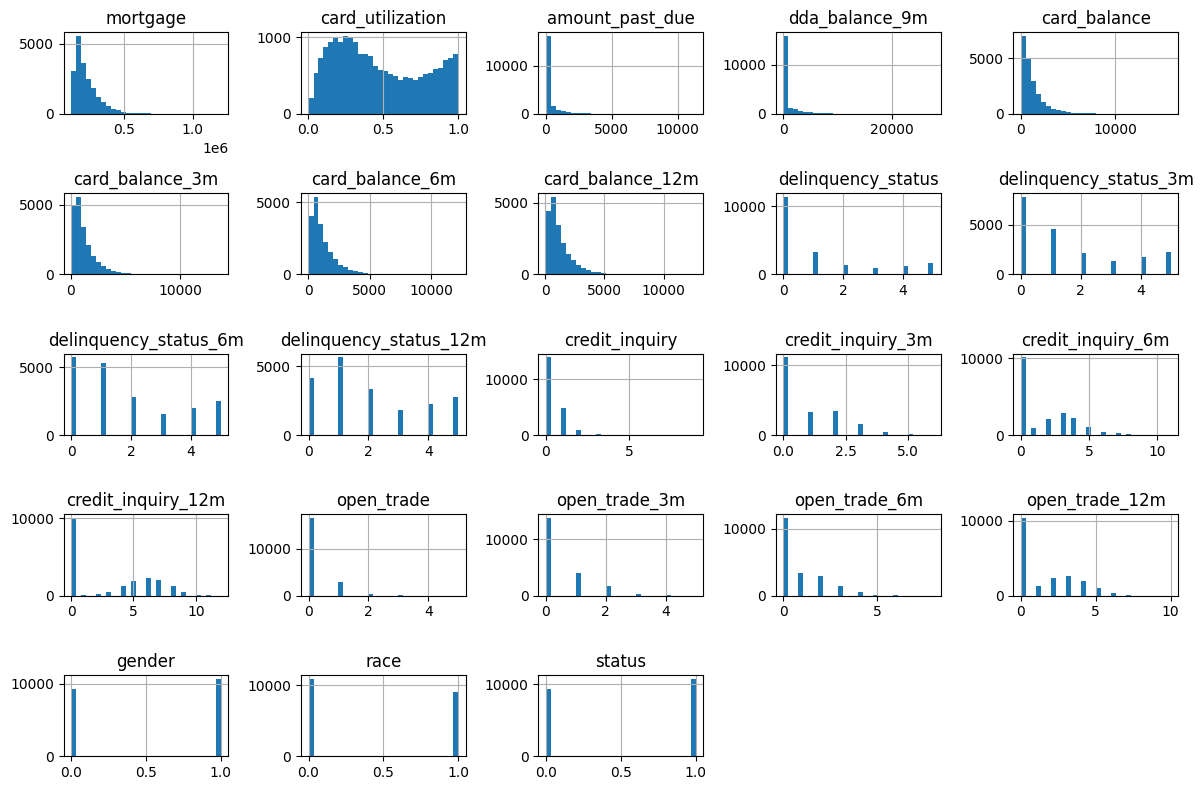

In [10]:
train.hist(bins=30, figsize=(12, 8))
plt.tight_layout()
plt.show()

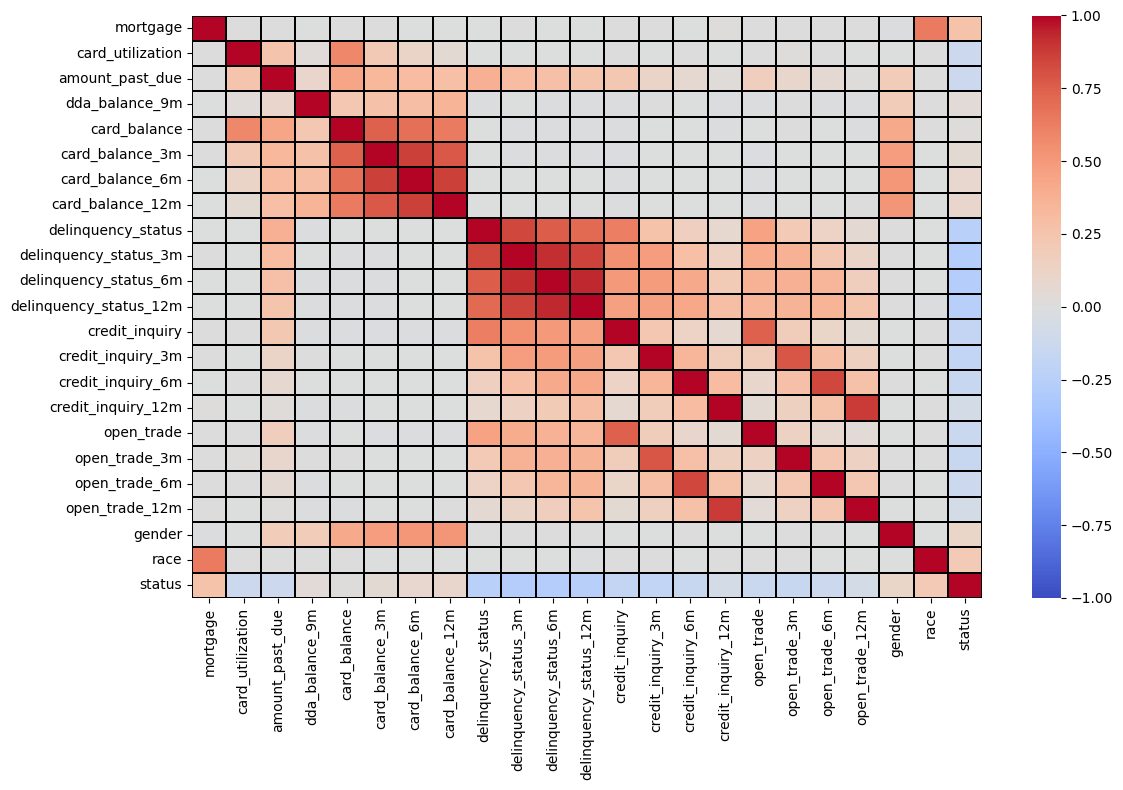

In [11]:
corr_mtx = train.drop('race_category', axis=1).corr()

fig, ax = plt.subplots(1, 1, figsize=(12, 8))
sns.heatmap(corr_mtx, cmap='coolwarm', vmin=-1, vmax=1, linewidths=0.01, linecolor='black', ax=ax)

plt.tight_layout()
plt.show()

In [12]:
corr_mtx['status'].sort_values(ascending=False)

status                    1.000000
mortgage                  0.258331
race                      0.204722
gender                    0.109261
card_balance_12m          0.093394
card_balance_6m           0.078222
card_balance_3m           0.054213
dda_balance_9m            0.039010
card_balance              0.012405
open_trade_12m           -0.073391
credit_inquiry_12m       -0.077696
amount_past_due          -0.125315
open_trade_6m            -0.125396
card_utilization         -0.131218
open_trade               -0.133383
open_trade_3m            -0.150071
credit_inquiry_6m        -0.153912
credit_inquiry           -0.176661
credit_inquiry_3m        -0.184851
delinquency_status       -0.242673
delinquency_status_12m   -0.254486
delinquency_status_6m    -0.267621
delinquency_status_3m    -0.269050
Name: status, dtype: float64

In [13]:
# Status (1, good) somewhat correlated with:
#   [x] Race + Gender, Mortgage
#   Card Balance, DDA Balance_9m
#       => proxies for wealth and solvency

# Status (1, good) somewhat anticorrelated with:
#   [x] Delinquency Status
#       => prior delinquency predicts future delinquency?

#   [x] Credit Inquiry, Open Trade
#       => opening many different accounts to finance spending is 
#           an example of poor financial decision-making

#   [x] Card Utilization, Amount Past Due
#       => person who makes poor financial decisions and uses their card 
#           for everything despite not being able to repay

# Interactions:
#   [x] Race + Mortgage
#       => differences of wealth and geographic region by race influence mortgage payment

#   [x] Gender + (Card Balance, DDA Balance_9m, Amount Past Due)
#       => wealth differences by gender (why does this affect amount past due?)

#   Delinquency Status + Credit Inquiry + Open Trade (+ respective lags)
#       => Open Trade and Credit Inquiry are obviously strongly correlated 
#           because opening a new account requires a credit check
#       => lagged terms have high correlation

#   [x] Card Balance + (Card Utilization, Amount Past Due, DDA Balance_9m)
#       => if you use your card, you will have a higher balance
#       => probably two different groups of people with high balances: 
#           (1) wealthy via DDA Balance_9m; (2) not wealthy via Amount Past Due

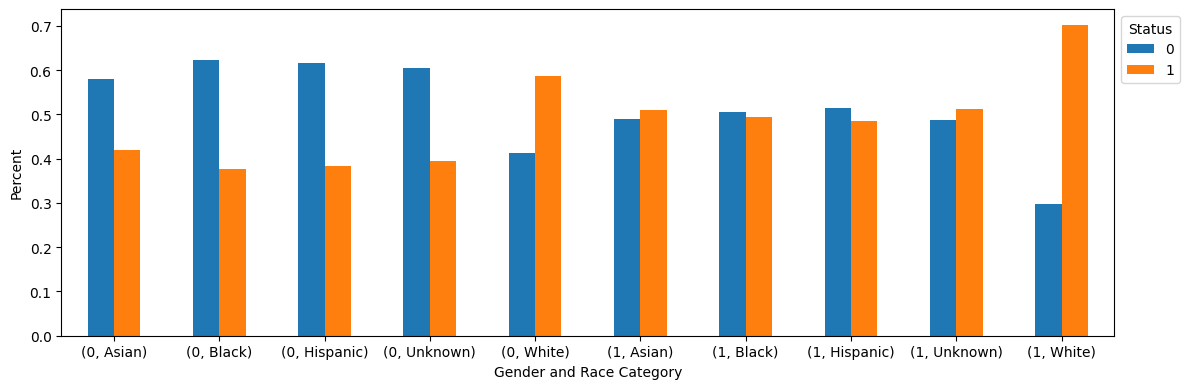

In [14]:
# relationship of race and gender to status?
# seems that we are not quite balanced in the status proportions between different groups
ax = train.groupby(['gender', 'race_category'])['status'].value_counts(normalize=True).unstack().plot(
        kind='bar', figsize=(12, 4), xlabel='Gender and Race Category', ylabel='Percent', rot=0
    )

ax.legend(title='Status', bbox_to_anchor=(1, 1), loc='upper left')

plt.tight_layout()
plt.show()

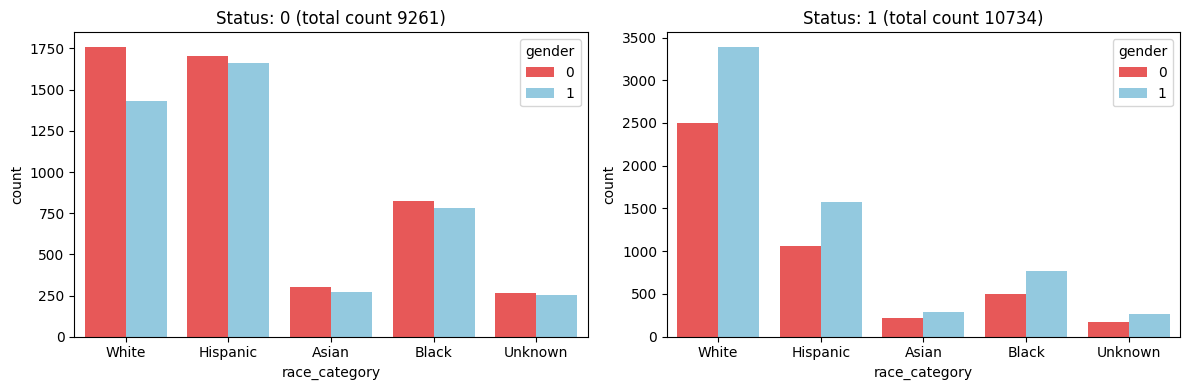

In [15]:
# how balanced are our race and gender categories, anyway?
# seems that the target labels are approximately evenly balanced. there is a bit of a 
# gender imbalance in the sample of people with status label 1 (males over-represented in all race categories)
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

for (i, g), ax in zip(train.groupby('status'), axes.flatten()):
    sns.countplot(g, x='race_category', hue='gender', palette=['#ff4040', '#87CEEB'], ax=ax)
    ax.set_title(f'Status: {i} (total count {len(g)})')

plt.tight_layout()
plt.show()

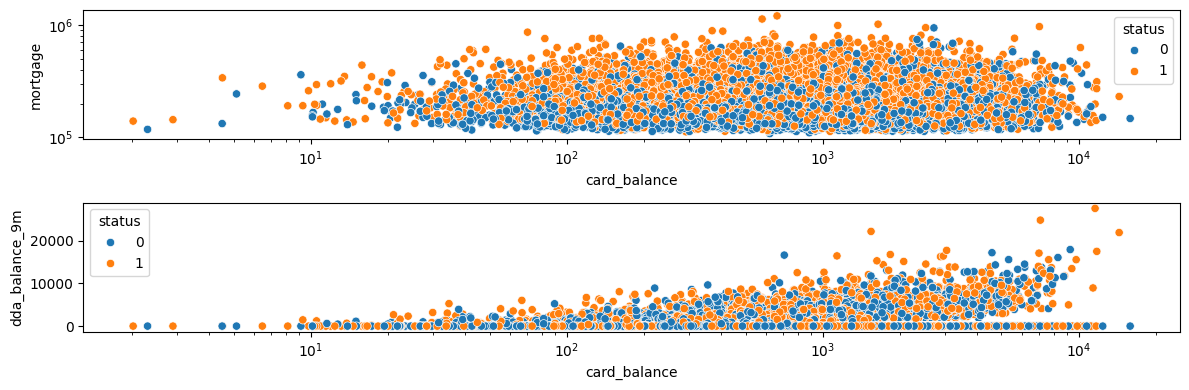

In [16]:
# relationship between mortgage, card balance, dda_balance_9m, and status?
# seems that samples with status =1 have somewhat higher mortgage amounts than those with status =0
# many people tend to have dda_balance_9m =0. how meaningful is it as a predictor?
fig, ax = plt.subplots(2, 1, figsize=(12, 4))
sns.scatterplot(train, x='card_balance', y='mortgage', hue='status', ax=ax[0])
sns.scatterplot(train, x='card_balance', y='dda_balance_9m', hue='status', ax=ax[1])

ax[0].set_xscale('log')
ax[0].set_yscale('log')
ax[1].set_xscale('log')

plt.tight_layout()
plt.show()

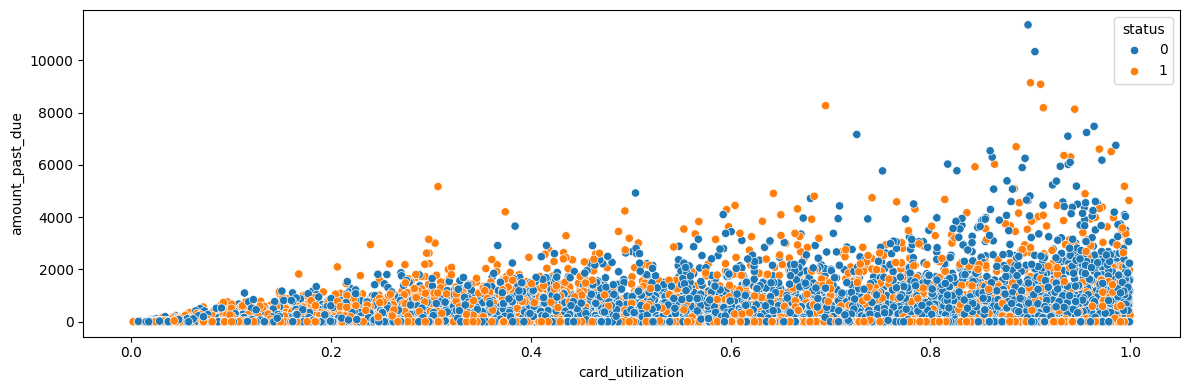

In [17]:
# relationship between card utilization and amount past due?
# seems that samples with status =1 tend to have low amounts past due and/or low card util.
fig, ax = plt.subplots(1, 1, figsize=(12, 4))
sns.scatterplot(train, x='card_utilization', y='amount_past_due', hue='status', ax=ax)

plt.tight_layout()
plt.show()

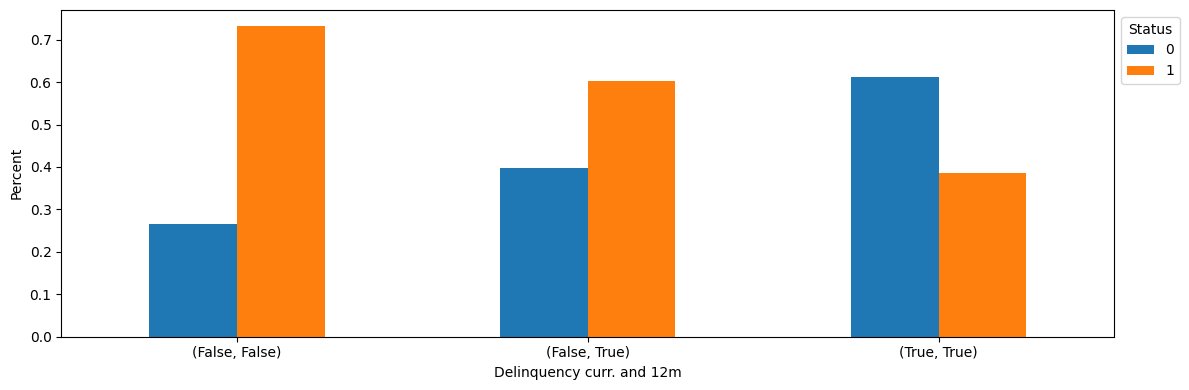

In [18]:
# can the existence of a delinquency in past 12m as well as currently inform us?
# it seems that those never delinquent are more likely to stay that way, while
# those that make an effort to repay their debts (i.e., no longer delinquent)
# correspond to status =1 more so than those that stay delinquent
train['bool_delinq_status'] = train['delinquency_status'] > 0
train['bool_delinq_status_12m'] = train['delinquency_status_12m'] > 0

ax = train.groupby(['bool_delinq_status', 'bool_delinq_status_12m'])['status'].value_counts(normalize=True).unstack().plot(
        kind='bar', figsize=(12, 4), xlabel='Delinquency curr. and 12m', ylabel='Percent', rot=0
    )

ax.legend(title='Status', bbox_to_anchor=(1, 1), loc='upper left')

plt.tight_layout()
plt.show()

train.drop(['bool_delinq_status', 'bool_delinq_status_12m'], axis=1, inplace=True)

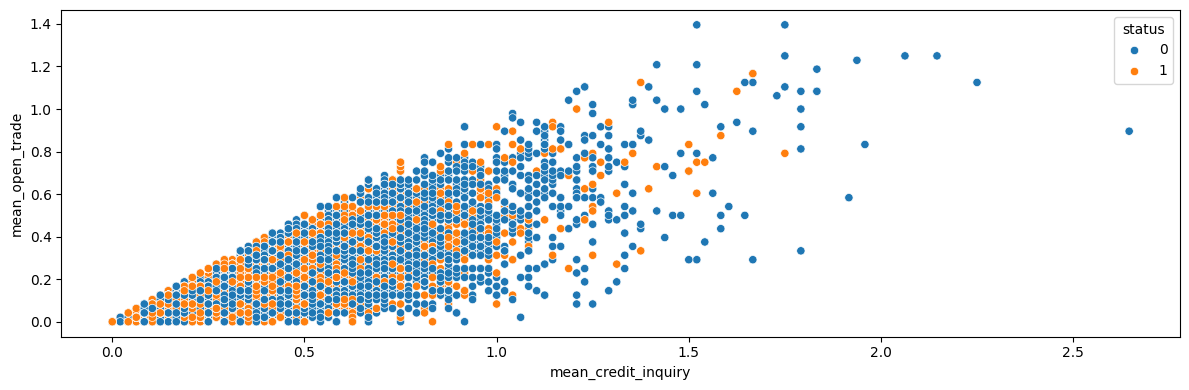

In [19]:
# relationship of credit_inquiry and open_trade?
# seems that samples with status =1 exhibit lower credit inquiries per an open tradeline
for col in ['credit_inquiry', 'open_trade']:
    all_cols = [f'{col}', f'{col}_3m', f'{col}_6m', f'{col}_12m']

    s = train[all_cols] / np.array([1, 3, 6, 12])
    train[f'mean_{col}'] = s.mean(axis=1).fillna(0)

    s = None

fig, ax = plt.subplots(1, 1, figsize=(12, 4))
sns.scatterplot(train, x='mean_credit_inquiry', y='mean_open_trade', hue='status', ax=ax)

plt.tight_layout()
plt.show()

train.drop(['mean_credit_inquiry', 'mean_open_trade'], axis=1, inplace=True)

Feature engineering

In [20]:
def engineer_features(df):
    temp = df.copy()
    
    # race + mortgage interaction
    temp['race_times_mortgage'] = temp['race'] * temp['mortgage']
    # gender + card balance interaction
    temp['gender_times_card_balance'] = temp['gender'] * temp['card_balance']
    # card_balance + card_utilization interaction
    temp['card_balance_card_util_ratio'] = temp['card_balance'] / temp['card_utilization']
    
    # getting the dummies for race and dropping extra race col
    temp = pd.get_dummies(temp, columns=['race_category']).drop('race', axis=1)

    # most people don't have a DDA balance at XYZ bank!
    temp['bool_dda_bal'] = temp['dda_balance_9m'] > 0

    # having high card utilization and a delinquent amount seem to interact
    temp['bool_util_and_past_due'] = (temp['card_utilization'] > 0.50) & (temp['amount_past_due'] > 0)

    # average and std of each of lagged totals after dividing by lag
    for col in ['credit_inquiry', 'delinquency_status', 'open_trade']:
        all_cols = [f'{col}', f'{col}_3m', f'{col}_6m', f'{col}_12m']

        s = temp[all_cols] / np.array([1, 3, 6, 12])
        temp[f'mean_{col}'] = s.mean(axis=1)
        temp[f'sd_{col}'] = s.std(axis=1)
        s = None

    # credit_inquiry and open_trade seem to interact
    temp['credit_inq_open_trade_ratio'] = temp.apply(lambda x: \
        x['mean_credit_inquiry'] / x['mean_open_trade'] if x['mean_open_trade'] > 0 else 0, axis=1)

    # grouping samples based on their delinquency trends
    def compute_delinquency_trend(x, col):
        if x[col] == 0:
            if x[f'{col}_12m'] == 0:
                # never delinquent
                return 1
            # not delinquent anymore
            return 0
        # still delinquent
        return -1
        
    temp[f'delinquency_status_trend'] = temp.apply(compute_delinquency_trend, col='delinquency_status', axis=1)

    # successive differences (relative) for card balance
    temp['delta_card_balance'] = temp.apply(
        lambda x: (x['card_balance'] / x['card_balance_3m']) - 1 if x['card_balance_3m'] > 0 else 0, axis=1)

    temp['delta_card_balance_3m'] = temp.apply(
        lambda x: (x['card_balance_3m'] / x['card_balance_6m']) - 1 if x['card_balance_6m'] > 0 else 0, axis=1)

    temp['delta_card_balance_6m'] = temp.apply(
        lambda x: (x['card_balance_6m'] / x['card_balance_12m']) - 1 if x['card_balance_12m'] > 0 else 0, axis=1)

    return temp

# engineering features for the train dataframe
temp = engineer_features(df=train)

Feature selection / sanity check (hierarchical feature clustering, UMAP embedding)

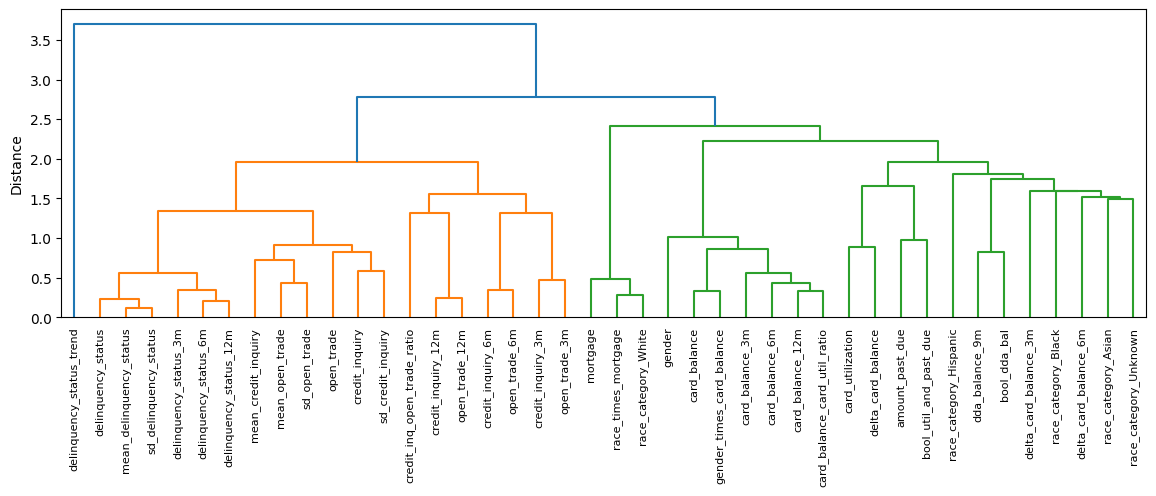

In [21]:
# not using status variable to prevent overfitting
new_corr_mtx = temp.drop('status', axis=1).corr()
linkage = hierarchy.linkage(new_corr_mtx, method='average')

plt.figure(figsize=(14, 4))

dendrogram = hierarchy.dendrogram(linkage, labels=new_corr_mtx.columns, leaf_rotation=90)

plt.ylabel('Distance')
plt.xticks(rotation=90)
plt.show()

In [22]:
def plot_umap_dbscan(df, k=2, umap_neighbors=100, min_clust_size=500, hue_col=None):
    # utility function for quickly visualizing embedding
    # need to ensure there is good separation between target classes based on feats.
    print(f'df has shape: {df.shape}')
    # standardizing features to mean 0 and unit variance
    scaler = StandardScaler()
    if hue_col is None:
        X_scaled = scaler.fit_transform(df)
    else:
        X_scaled = scaler.fit_transform(df.drop(hue_col, axis=1))

    # computing UMAP embedding
    reducer = umap.UMAP(n_neighbors=umap_neighbors, n_components=k, metric='canberra', init='random', verbose=False)
    embedding = reducer.fit_transform(X_scaled)

    clusterer = hdbscan.HDBSCAN(min_cluster_size=min_clust_size, metric='euclidean').fit(embedding)

    fig, ax = plt.subplots(1, 2, figsize=(12, 4))
    sns.scatterplot(x=embedding[:, 0], y=embedding[:, 1], hue=None if not hue_col else df[hue_col], ax=ax[0])
    sns.scatterplot(x=embedding[:, 0], y=embedding[:, 1], hue=clusterer.labels_, ax=ax[1], palette='dark')
    plt.tight_layout()
    plt.show()

df has shape: (19995, 43)


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


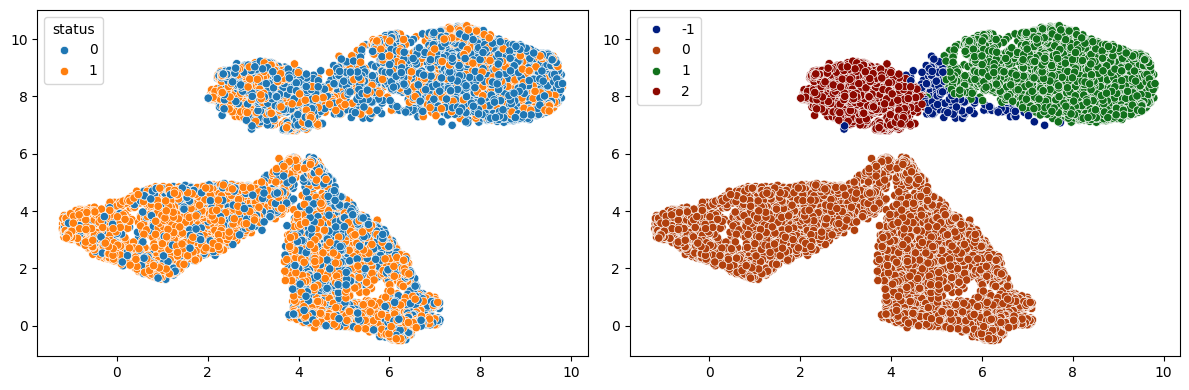

In [23]:
plot_umap_dbscan(temp, hue_col='status')

df has shape: (19995, 18)


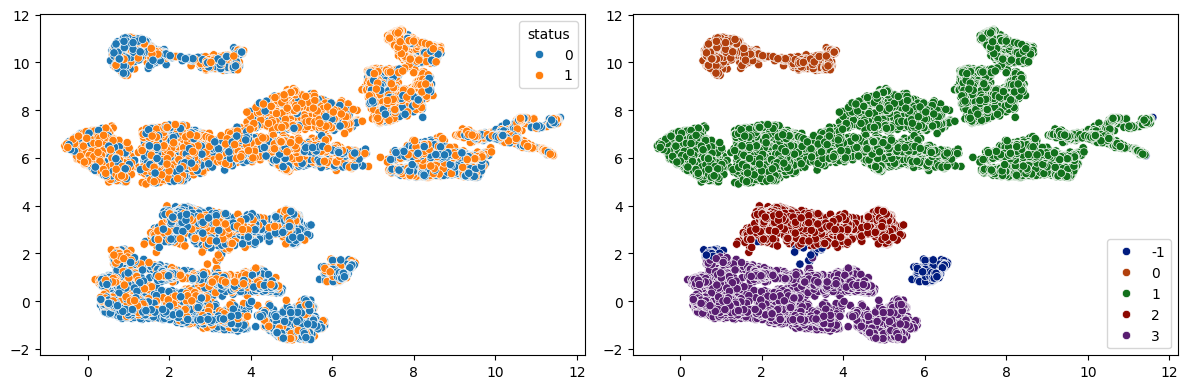

In [24]:
# lets filter out some features which are seemingly similar to others
subset_cols = [
    'delinquency_status_trend',
    
    'mean_delinquency_status', 'sd_delinquency_status', 'delinquency_status_12m',
    'mean_credit_inquiry', 'sd_credit_inquiry', 'credit_inquiry_12m',

    'credit_inq_open_trade_ratio',

    'mortgage', 'gender', 'race_category_White', 'race_category_Hispanic',
    'gender_times_card_balance',  'card_balance_card_util_ratio',

    'card_balance', 'card_balance_12m',
    
    'card_utilization',
    'status'
]

plot_umap_dbscan(temp[subset_cols], hue_col='status')

Exporting both train and test

In [25]:
temp[subset_cols].to_csv(f'{data_dir}/{processed}/train_proc.csv', index=False)

In [26]:
test = pd.read_csv(f'{data_dir}/{processed}/{test_fname}')

# engineering features for the test dataframe
temp = engineer_features(df=test)
temp[subset_cols].to_csv(f'{data_dir}/{processed}/test_proc.csv', index=False)